# Layer-wise Propagation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.ops import gen_nn_ops
import ipywidgets as widgets
from ipywidgets import interact_manual
import warnings
import copy
from io import BytesIO

In [2]:
from xaiLRP import LRP

In [15]:
(train_X, train_y) , (test_X, test_y) = tf.keras.datasets.fashion_mnist.load_data()

input_shape = (-1, *train_X.shape[1:], 1)

In [41]:
tf.__version__

'2.1.0'

### Create Model

In [20]:
# Create model

strides = (1,1)
n = len(np.unique(train_y))
CNN = tf.keras.Sequential()

CNN.add(Conv2D(input_shape = input_shape[1:],
               filters = 3, kernel_size = (5,5),
               strides = strides, padding="same", 
               activation = 'relu'))

CNN.add(MaxPool2D(pool_size = (2,2)))

CNN.add(Conv2D(filters = 3, kernel_size = (5,5),
               strides = strides, padding = "same",
               activation = 'relu'))

CNN.add(MaxPool2D(pool_size = (2,2)))

CNN.add(Conv2D(filters = 3, kernel_size = (5,5),
               strides = strides, padding = "same",
               activation = 'relu'))

CNN.add(MaxPool2D(pool_size = (2,2)))

CNN.add(Conv2D(filters = 20, kernel_size = (5,5),
               strides = strides, padding = "same",
               activation = 'relu'))

#CNN.add(Dropout(1.0))

CNN.add(Flatten())

CNN.add(Dense(units = n, activation = "softmax"))

CNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 3)         78        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 3)         228       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 3)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 3)           228       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 3)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 20)         

In [23]:
CNN.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

CNN.fit(train_X.reshape(input_shape), train_y, epochs = 7, batch_size=6000, validation_split=0.25
            , callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")])

Train on 45000 samples, validate on 15000 samples
Epoch 1/7
45000/45000 [==============================] - 7s 160us/sample - loss: 17.1196 - accuracy: 0.0940 - val_loss: 5.1339 - val_accuracy: 0.1572
Epoch 2/7
45000/45000 [==============================] - 7s 157us/sample - loss: 3.8344 - accuracy: 0.1698 - val_loss: 2.6280 - val_accuracy: 0.1871
Epoch 3/7
45000/45000 [==============================] - 7s 155us/sample - loss: 2.3254 - accuracy: 0.2198 - val_loss: 2.1043 - val_accuracy: 0.2579
Epoch 4/7
45000/45000 [==============================] - 8s 186us/sample - loss: 1.9726 - accuracy: 0.2981 - val_loss: 1.7769 - val_accuracy: 0.3749
Epoch 5/7
45000/45000 [==============================] - 9s 194us/sample - loss: 1.6764 - accuracy: 0.3992 - val_loss: 1.5685 - val_accuracy: 0.4233
Epoch 6/7
45000/45000 [==============================] - 9s 191us/sample - loss: 1.5232 - accuracy: 0.4240 - val_loss: 1.4654 - val_accuracy: 0.4433
Epoch 7/7
45000/45000 [==============================] 

In [5]:
CNN.save("./CNN_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./CNN_model/assets


### Load Model

In [25]:
# (train_X, train_y) , (test_X, test_y) = tf.keras.datasets.mnist.load_data()
(train_X, train_y) , (test_X, test_y) = tf.keras.datasets.fashion_mnist.load_data()

CNN = tf.keras.models.load_model("./CNN_model")

In [26]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 3)         78        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 3)         228       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 3)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 20)          1520      
_________________________________________________________________
flatten (Flatten)            (None, 980)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                9

### Visualize by layers

In [33]:
class visLayer():
    def __init__(self, data, N, layers):
        self.data = data
        self.N = N
        self.layers = layers
        self.n_layers = len(layers)
        
        self.by_data = dict()
        
        for i in range(N):
            tmp = self.data[i]
            tmp = tf.cast(tmp.reshape(-1,*tmp.shape,1), tf.float32)
            data_activation = [tmp]
            for layer in self.layers:
                tmp = layer(tmp)
                data_activation.append(tmp)
            self.by_data["data_{}".format(i)] = data_activation

    
    def show(self):
        for data_depict in self.by_data.values():
            plt.figure(figsize = ((self.n_layers+1)*5,5))
            for i, image in enumerate(data_depict):
                plt.subplot(1, self.n_layers+1, i+1)
                collapse = tf.math.reduce_mean(image, axis = 3)
                plt.imshow(tf.reshape(collapse, collapse.shape[1:]), interpolation = "nearest", cmap = "gray")
            plt.show()
            
        

In [34]:
layers = []
for layer in CNN.layers:
    if ("Conv" in str(layer)) or ("MaxPooling" in str(layer)):
        layers.append(layer)

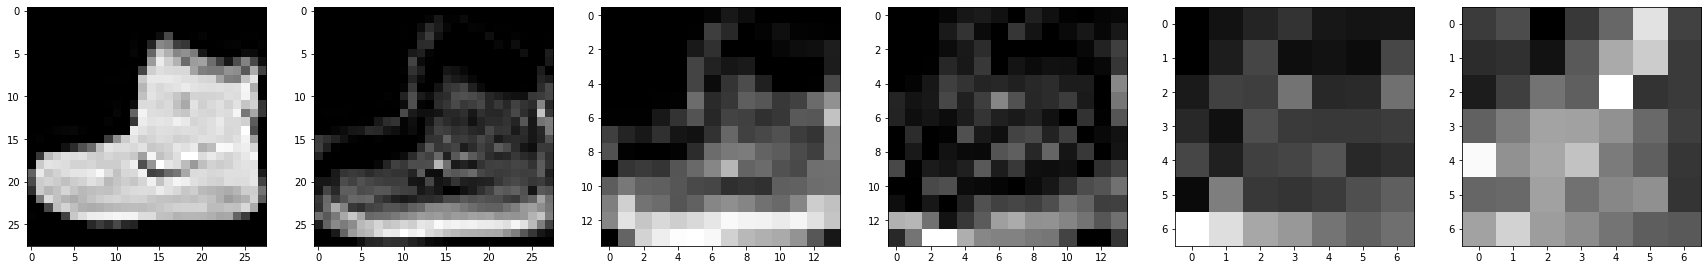

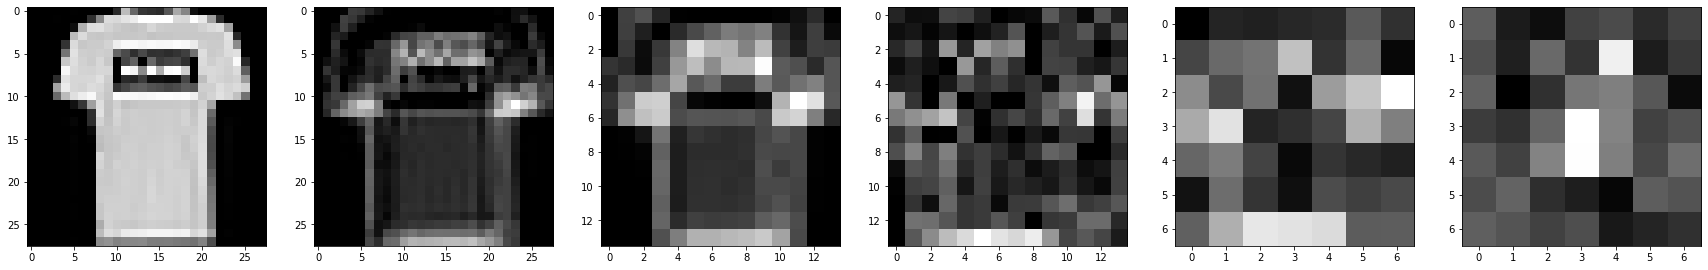

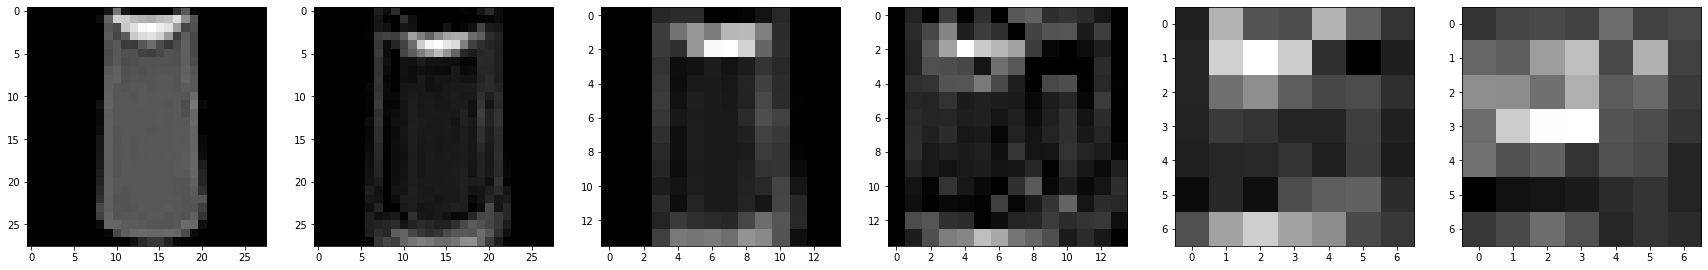

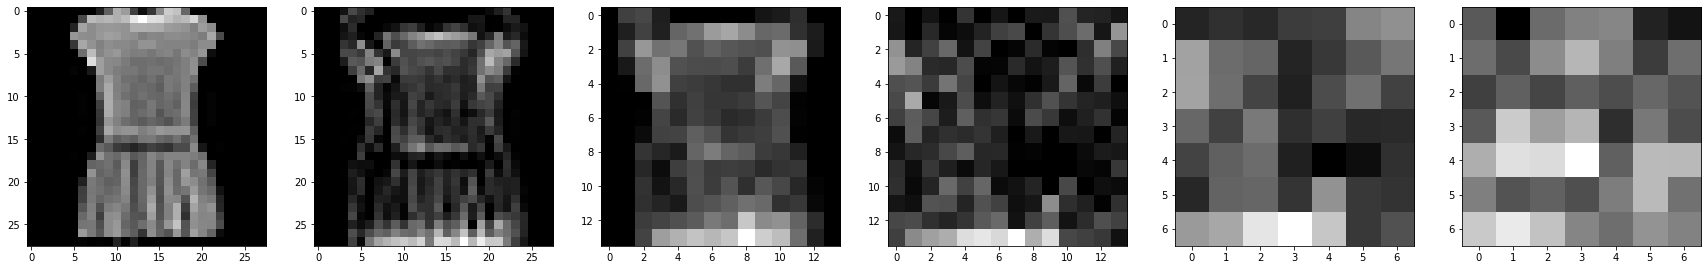

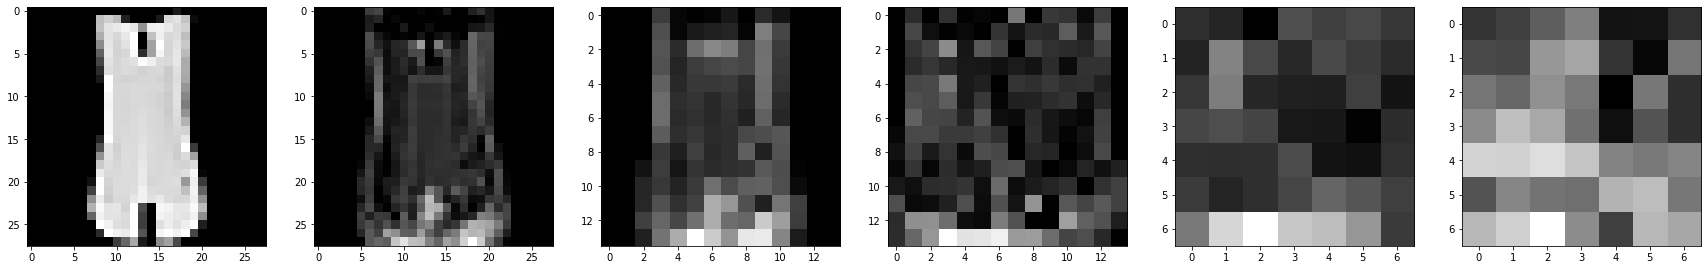

In [36]:
visLayer(train_X, layers = layers, N = 5).show()

### LRP

In [7]:
lrp = LRP(model = CNN,data_shape=input_shape)

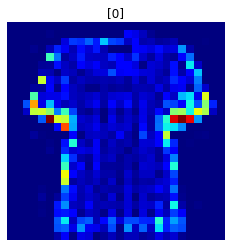

In [40]:
from PIL import Image
import random
image = lrp.get_LRP(train_X[random.randint(0,10000),:])
stream = BytesIO(image.read())
image = Image.open(stream).convert("RGBA")
stream.close()
image.show()